# Titanic Survival Prediction

## Importing Libraries and Datasets

In [2]:
# Import Packages for Feature Engineering and Data Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Import Packages for Machine Learning Modelling
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

In [3]:
# Import Datasets
train = pd.read_csv("C:/Users/New/GitProjects/MyProjects/Predicting-Titanic-Survivors/Datasets/train.csv")
test = pd.read_csv("C:/Users/New/GitProjects/MyProjects/Predicting-Titanic-Survivors/Datasets/test.csv")

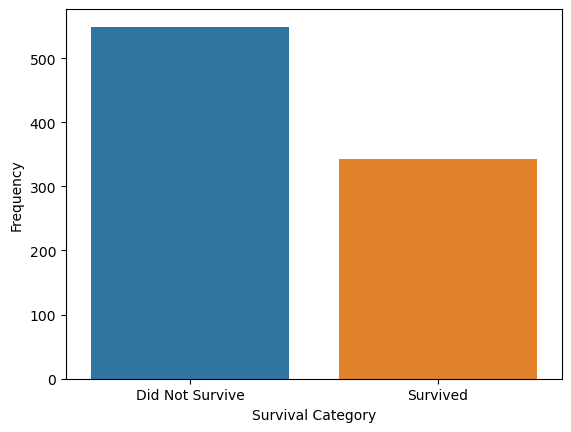

In [4]:
# Plot Target Distribution In Train Dataset
sns.countplot(data=train, x='Survived')
plt.ylabel('Frequency')
plt.xlabel('Survival Category')
plt.xticks([0.0, 1.0], ['Did Not Survive', 'Survived']);

## Feature Engineering and Data Cleaning

In [5]:
# Create Wrangler Function to Preprocess and Clean Dataset
def wrangler (df):
    df = df.copy()
    # Replace Column Elements for Readability
    emb = {"Q" : "Queenstown" , "S" : "Southampton" , "C" : "Cherbourg" }
    df['Embarked'].replace(emb)
    
    cla = {1:"First Class", 2: "Second Class", 3 :"Third Class"}
    df['Pclass'].replace(cla).astype('object')

    # Transform Ticket into Lettered Column by Ticket Type (Numeric or Alphanumeric Ticket)
    def has_letters(string):
        return any(char.isalpha() for char in string)
    df['Ticket_Type'] = df['Ticket'].apply(has_letters).astype('object')
    
    # Separate Dataset Features into Categorical and Numeric Variable (Useful For Visualizations)
    num_cols = list(df.select_dtypes(exclude=['object']).columns)
    cat_cols = list(df.select_dtypes(include=['object']).columns)
    
    # Encode the Categorical Features
    le = LabelEncoder()
    for col in cat_cols:
        le.fit(df[col])
        df[col] = le.transform(df[col])
      
    # Dropped Unneeded Columns After Feature Engineering
    drop_cols = []
    drop_col_list = ["Name", "Cabin", "Ticket"]
    for col in df.columns:
        if col in drop_col_list:
            drop_cols.append(col)
    
    df = df.drop(columns = drop_cols)
    return df

In [6]:
# Preprocess Test and Train Datasets
train = wrangler(train)
test = wrangler(test)

# Create Target, Features, and Train-Test Split
X_train = train.drop(['Survived', 'PassengerId' ], axis=1)
y_train = train['Survived']
X_test = test.drop(['PassengerId' ], axis=1)

## Prediction Using the Logistic Regression Model

In [6]:
# Create Pipeline With Scaler, Imputer and Model  
model = LogisticRegression(random_state= 42, max_iter=1000)
scaler = RobustScaler()
imputer = KNNImputer(n_neighbors=5)
pipeline = Pipeline(steps=[('i', imputer), ('s', scaler) , ('m', model)])

# Fit the Pipeline on Training Data
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

 Training Accuracy: 0.8069584736251403


In [7]:
# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions = pipeline.predict(X_test)
model_output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
model_output.to_csv('C:/Users/New/Downloads/LRPredictions.csv', index=False)

# Check how many survivors/non-survivors the Model Predicted
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

# Save Model to a .pkl File 
pickle.dump(pipeline, open('C:/Users/New/GitProjects/MyProjects/Predicting-Titanic-Survivors/Models/LRModel.pkl', 'wb'))

## Prediction Using the Logistic Regression Cross Validation Model

In [8]:
# Create Pipeline With Scaler, Imputer and Model
model = LogisticRegressionCV(cv=5, max_iter = 1000, random_state=42, n_jobs=-1)
scaler = RobustScaler()
imputer = KNNImputer(n_neighbors=5)
pipeline = Pipeline(steps=[('i', imputer), ('s', scaler) , ('m', model)])

# Fit the Pipeline on Training Data
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

 Training Accuracy: 0.8080808080808081


In [9]:
# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions = pipeline.predict(X_test)
model_output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
model_output.to_csv('C:/Users/New/Downloads/LRCVPredictions.csv', index=False)

# Check how many survivors/non-survivors the Model Predicted
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

# Save Model to a .pkl File 
pickle.dump(pipeline, open('C:/Users/New/GitProjects/MyProjects/Predicting-Titanic-Survivors/Models/LRCVModel.pkl', 'wb'))

## Prediction Using the Decision Tree Classifier

In [10]:
# Create Pipeline With Scaler, Imputer and Model
pipeline = Pipeline([('scaler', StandardScaler()),  ('imputer', KNNImputer(n_neighbors=5)), ('classifier', DecisionTreeClassifier(random_state=42))])

# Prepare Hyperparameter Tuning Dictionary
param_grid = {'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [None, 5, 10, 15],
              'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4]}

# Tune Hyperparameters 
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Select the Best Estimator to Fit Training Data
best_estimator = grid_search.best_estimator_
accuracy = best_estimator.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
 Training Accuracy: 0.8473625140291807


In [11]:
# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions = best_estimator.predict(X_test)
model_output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
model_output.to_csv('C:/Users/New/Downloads/DTCPredictions.csv', index=False)

# Check how many survivors/non-survivors the Model Predicted
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

# Save Model to a .pkl File 
pickle.dump(pipeline, open('C:/Users/New/GitProjects/MyProjects/Predicting-Titanic-Survivors/Models/DTCModel.pkl', 'wb'))

## Prediction Using Random Forest Classifier

In [12]:
# Create Pipeline With Scaler, Imputer and Model
pipeline = Pipeline([('scaler', StandardScaler()),  ('imputer', KNNImputer(n_neighbors=5)), ('classifier', RandomForestClassifier(random_state=42))])

# Prepare Hyperparameter Tuning Dictionary
param_grid = {'classifier__n_estimators': [100, 200, 300], 'classifier__max_depth': [None, 5, 10, 15],
              'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4], 'classifier__bootstrap': [True, False]}
# Tune Hyperparameters 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
#grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Select the Best Estimator to Fit Training Data
best_estimator = grid_search.best_estimator_
accuracy = best_estimator.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

Fitting 15 folds for each of 216 candidates, totalling 3240 fits
Best Parameters: {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
 Training Accuracy: 0.9012345679012346


In [13]:
# Make Survival Prediction in the Test Dataset and Save Results to Excel File
predictions = best_estimator.predict(X_test)
model_output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
model_output.to_csv('C:/Users/New/Downloads/RFCPredictions.csv', index=False)

# Check how many survivors/non-survivors the Model Predicted
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

# Save Model to a .pkl File 
pickle.dump(pipeline, open('C:/Users/New/GitProjects/MyProjects/Predicting-Titanic-Survivors/Models/RFCModel.pkl', 'wb'))

## Check Feature Importance of Best Model and Save Best Model for Web App

In [14]:
# Saving the Best Model to appmodel.pkl for Web App
pipeline = Pipeline([('scaler', StandardScaler()),  ('imputer', KNNImputer(n_neighbors=5)), ('classifier', DecisionTreeClassifier(random_state=42, criterion = 'entropy', max_depth = 5, min_samples_leaf = 2, min_samples_split = 2))])
pipeline.fit(X_train, y_train)
pickle.dump(pipeline, open('C:/Users/New/GitProjects/MyProjects/Predicting-Titanic-Survivors/appmodel.pkl', 'wb'))

# Extracting Feature Importance in the Best Model
decision_tree = pipeline.named_steps['classifier']
importances = decision_tree.feature_importances_
feature_names = X_train.columns
feature_importances = dict(zip(feature_names, importances))

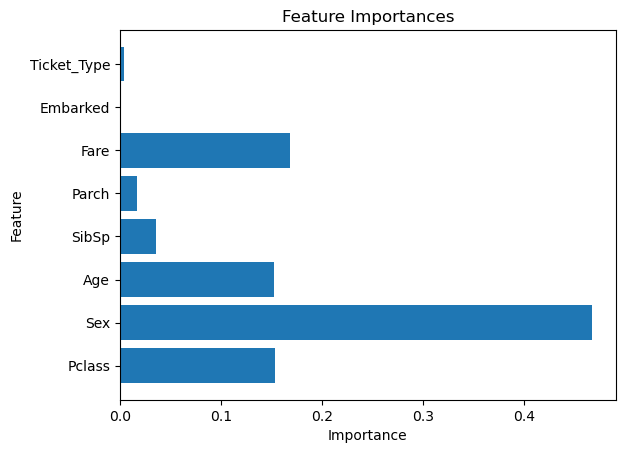

In [15]:
# Visualization of the Most Important Determinants of Survival
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()